# 视觉里程计
学号：23103402  
姓名：丁悦林

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import bisect
import pandas as pd

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## RGB ORB 单目VO

根据txt文件中的描述“rgbd_dataset_freiburg2_desk.bag”，应该是属于tum数据集的freiburg2系列。

所以使用tum数据集fr2系列的参数。

In [38]:
# tum数据集fr2系列
# 相机内参
K = np.array([[520.9, 0.0, 325.1],
              [0.0, 521.0, 249.7],
              [0.0, 0.0, 1.0]])

# 畸变系数[k1, k2, p1, p2, k3]
dist_coef = np.array([0.2312, -0.7849, -0.0033, -0.0001, 0.9172])

In [26]:
def load_images_from_tum(path):
    """
    读取TUM数据集的 rgb.txt 文件，解析文件名并排序
    """
    rgb_txt_path = os.path.join(path, 'rgb.txt')
    image_files = []
    timestamps = []
    
    if not os.path.exists(rgb_txt_path):
        print(f"Error: {rgb_txt_path} not found.")
        return [], []
        
    with open(rgb_txt_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split()
            if len(parts) >= 2:
                timestamp = float(parts[0])
                filename = os.path.join(path, parts[1])
                timestamps.append(timestamp)
                image_files.append(filename)
    
    return image_files, timestamps

In [27]:
dataset_path = "../data/chaoxing_data/tum"
# 加载图片列表
images, times = load_images_from_tum(dataset_path)
print(f"共加载了 {len(images)} 帧图像")

共加载了 2965 帧图像


In [28]:
def detect_features(img):
    """
    使用 ORB 提取特征点和描述子
    """
    orb = cv2.ORB_create(nfeatures=3000) # 提取3000个特征点以保证鲁棒性
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def match_features(des1, des2):
    """
    使用 BFMatcher 进行特征匹配，并使用 Lowe's Ratio Test 过滤
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance: # 0.75 是常用的阈值
            good_matches.append(m)
            
    return good_matches

def estimate_motion(kp1, kp2, matches, K):
    """
    计算两帧之间的位姿变化 (R, t)
    """
    # 提取匹配点的坐标
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # 1. 计算本质矩阵 E (RANSAC 包含在内，方法使用 cv2.RANSAC)
    # prob=0.999, threshold=1.0 (像素误差阈值)
    E, mask = cv2.findEssentialMat(pts2, pts1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    if E is None or E.shape != (3, 3):
        return None, None, None
        
    # 2. 从本质矩阵恢复位姿 R, t
    _, R, t, mask_pose = cv2.recoverPose(E, pts2, pts1, K)
    
    return R, t, mask # mask用于后续可视化或统计inliers

In [29]:
# Cell 4: VO 主循环 (添加畸变校正)

def run_mono_vo(images, K, dist_coef):
    # 初始化全局位姿
    # 定义相机在世界坐标系的初始位置和姿态
    cur_R = np.eye(3)
    cur_t = np.zeros((3, 1))
    
    trajectory = [] # 存储 [x, y, z]
    trajectory.append(cur_t.flatten())
    
    # === 读取第一帧 ===
    prev_img = cv2.imread(images[0])
    if prev_img is None:
        raise ValueError("无法读取第一帧图像")
        
    # 畸变校正
    # 注意：newCameraMatrix=K 保证校正后的图像仍符合原来的内参 K
    # 这样后续 estimate_motion 时可以直接使用 K
    prev_img = cv2.undistort(prev_img, K, dist_coef, None, K)
    
    # 转灰度
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    
    # 提取第一帧特征
    prev_kp, prev_des = detect_features(prev_gray)
    
    print("开始处理视频序列 (已启用畸变校正)...")
    
    # === 循环处理后续帧 ===
    for i in range(1, len(images)):
        curr_img = cv2.imread(images[i])
        
        # 畸变校正 (当前帧)
        curr_img = cv2.undistort(curr_img, K, dist_coef, None, K)
        
        curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        
        # 1. 特征提取
        curr_kp, curr_des = detect_features(curr_gray)
        
        # 2. 特征匹配
        if prev_des is None or curr_des is None:
            continue
        matches = match_features(prev_des, curr_des)
        
        # 3. 运动估计
        if len(matches) < 8: # 8点法求解E矩阵的最低要求
            continue
            
        R, t, mask = estimate_motion(prev_kp, curr_kp, matches, K)
        
        if R is not None:
            # ====================================================
            # 尺度问题说明：
            # 实验一中我们尚未引入GroundTruth，因此 t 是归一化的 (模长=1)
            # 这里的 absolute_scale = 1.0 意味着假设每一帧相机移动距离恒定
            # 这会导致轨迹形状正确但比例尺不对
            # ====================================================
            absolute_scale = 1.0 
            
            # 简单的防抖动处理
            if absolute_scale > 0.1: 
                # 更新全局位姿
                # 公式：t_world = t_world + R_world * (scale * t_local)
                # 公式：R_world = R_world * R_local
                cur_t = cur_t + absolute_scale * cur_R.dot(t)
                cur_R = cur_R.dot(R)
                
            trajectory.append(cur_t.flatten()) # trajectory存储位移向量[x, y, z]
            
        # 更新上一帧数据
        prev_gray = curr_gray
        prev_kp = curr_kp
        prev_des = curr_des
        
        # 打印进度
        if i % 50 == 0:
            print(f"Processing frame {i}/{len(images)} ...")
            
    return np.array(trajectory)

In [33]:
# 运行 (可以切片 images[:xxx])
traj_est = run_mono_vo(images[:500], K, dist_coef)
print("处理完成。")

开始处理视频序列 (已启用畸变校正)...
Processing frame 50/500 ...
Processing frame 100/500 ...
Processing frame 150/500 ...
Processing frame 200/500 ...
Processing frame 250/500 ...
Processing frame 300/500 ...
Processing frame 350/500 ...
Processing frame 400/500 ...
Processing frame 450/500 ...
处理完成。


In [48]:
# Cell 5: 结果可视化

def plot_trajectory(traj):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # 提取 X 和 Z 坐标
    # traj 的形状是 (N, 3)，分别是 x, y, z
    x = traj[:, 0]
    z = traj[:, 2] # 也是前进方向
    
    ax.plot(x, z, label='估计的轨迹 (单目)', color='blue', linewidth=2)
    ax.scatter(x[0], z[0], color='red', s=80, label='起点')  # s为点大小
    
    ax.set_title(f'单目视觉里程计轨迹(X-Z平面，前{len(traj)}帧)', fontsize=16)
    ax.set_xlabel('X (米) - 比例任意', fontsize=12)
    ax.set_ylabel('Z (米) - 比例任意', fontsize=12)
    ax.legend()
    ax.axis('equal') # 保证比例一致，否则形状会变形
    plt.show()

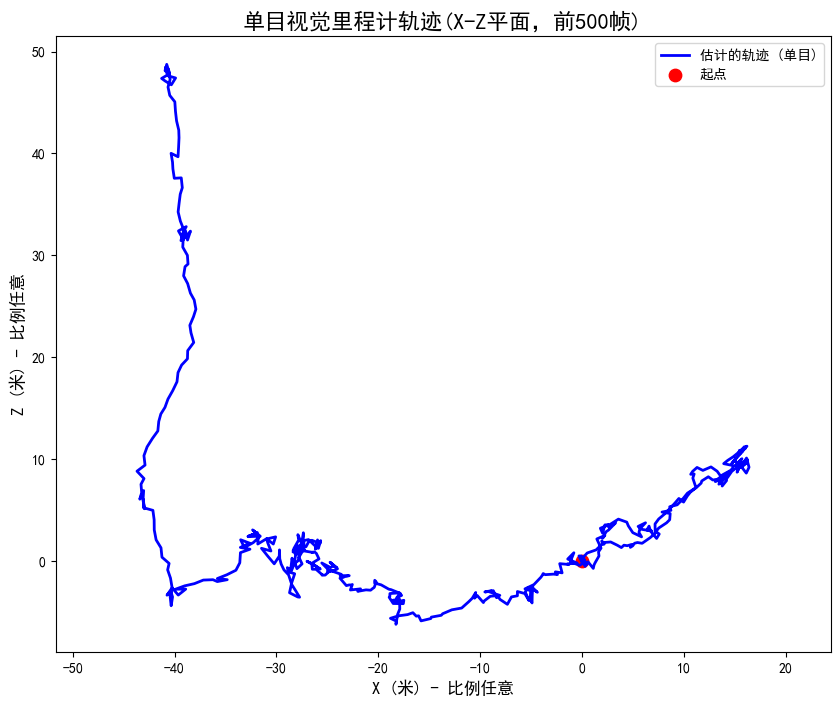

In [49]:
if len(traj_est) > 0:
    plot_trajectory(traj_est)
else:
    print("没有生成有效的轨迹。")

## RGB->GT 数据关联

In [ ]:
# Cell 6: 读取 Ground Truth 数据

def load_groundtruth(dataset_path):
    """
    读取 groundtruth.txt 文件
    返回: 
        gt_data: 字典 {timestamp: [tx, ty, tz]} 
                 (为了简化，暂时只取位置，如果需要四元数也可以加上)
        gt_timestamps: 排序后的时间戳列表，用于二分查找
    """
    gt_path = os.path.join(dataset_path, 'groundtruth.txt')
    
    gt_data = {}
    gt_timestamps = []
    
    if not os.path.exists(gt_path):
        print(f"Error: {gt_path} not found.")
        return {}, []
    
    print(f"正在读取 Ground Truth: {gt_path}")
    with open(gt_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split()
            if len(parts) >= 8: # 一行即为 timestamp tx ty tz qx qy qz qw
                t = float(parts[0])
                # 这里只提取位置 x, y, z
                pos = np.array([float(parts[1]), float(parts[2]), float(parts[3])])
                
                gt_data[t] = pos
                gt_timestamps.append(t)
    
    gt_timestamps.sort() # 二分查找必须有序
    print(f"加载了 {len(gt_timestamps)} 条 Ground Truth 记录")
    return gt_data, gt_timestamps

In [40]:
# 加载数据
gt_dict, gt_times_list = load_groundtruth(dataset_path)

正在读取 Ground Truth: ../data/chaoxing_data/tum\groundtruth.txt
加载了 20957 条 Ground Truth 记录


In [ ]:
# Cell 7: 时间戳同步 (Data Association)

def find_nearest_timestamp(target_time, sorted_times):
    """
    在有序列表 sorted_times 中找到与 target_time 最接近的时间戳
    使用 bisect 二分查找
    """
    idx = bisect.bisect_left(sorted_times, target_time)
    
    # idx 是插入位置，可能的最近邻是 idx 或 idx-1
    if idx == 0:
        return sorted_times[0]
    if idx == len(sorted_times):
        return sorted_times[-1]
    
    before = sorted_times[idx - 1]
    after = sorted_times[idx]
    
    if after - target_time < target_time - before:
        return after
    else:
        return before

def associate_data(est_timestamps, est_traj, gt_dict, gt_times_list, max_time_diff=0.02):
    """
    将估算轨迹与 GT 进行时间对齐
    """
    matched_data = []
    
    # 确保估算数据的长度一致
    assert len(est_timestamps) == len(est_traj), "时间戳与轨迹点数量不匹配"
    
    print(f"开始对齐 {len(est_timestamps)} 帧估算数据...")
    
    for i, t_rgb in enumerate(est_timestamps):
        # 1. 寻找最近的 GT 时间戳
        t_gt = find_nearest_timestamp(t_rgb, gt_times_list) # 二分查找
        
        # 2. 计算时间差
        diff = abs(t_rgb - t_gt)
        
        # 3. 阈值判定 (通常 0.02s 内认为匹配成功)
        if diff < max_time_diff:
            # 提取数据
            est_pos = est_traj[i] # [x, y, z] 估算值
            gt_pos = gt_dict[t_gt] # [x, y, z] 真值
            
            # 构建一行数据
            # 格式: [rgb_time, est_x, est_y, est_z, gt_time, gt_x, gt_y, gt_z]
            row = {
                'timestamp_rgb': t_rgb,
                'est_x': est_pos[0],
                'est_y': est_pos[1],
                'est_z': est_pos[2],
                'timestamp_gt': t_gt,
                'gt_x': gt_pos[0],
                'gt_y': gt_pos[1],
                'gt_z': gt_pos[2],
                'time_diff': diff
            }
            matched_data.append(row)
            
    print(f"匹配成功: {len(matched_data)} / {len(est_timestamps)} 帧")
    return pd.DataFrame(matched_data)

In [45]:
# === 执行对齐 ===
# 注意：times 是所有图片的时间戳，需要切片前 len(traj_est) 个
# 之前跑的是 images[:500]，那么 traj_est 长度就是 500，对应times[:500]

current_est_timestamps = times[:len(traj_est)]
df_matched = associate_data(current_est_timestamps, traj_est, gt_dict, gt_times_list)

# 显示前5行预览
df_matched.head()

开始对齐 500 帧估算数据...
匹配成功: 450 / 500 帧


,timestamp_rgb,est_x,est_y,est_z,timestamp_gt,gt_x,gt_y,gt_z,time_diff
0,1.311868e+09,0.000000,0.000000,0.000000,1.311868e+09,-0.1546,-1.4445,1.4773,0.000019
1,1.311868e+09,0.307506,-0.793291,-0.525480,1.311868e+09,-0.1578,-1.4458,1.4770,0.000774
2,1.311868e+09,0.582658,-1.644854,-0.079239,1.311868e+09,-0.1601,-1.4472,1.4767,0.001140
3,1.311868e+09,1.098858,-2.202891,-0.728955,1.311868e+09,-0.1633,-1.4501,1.4766,0.000145
4,1.311868e+09,1.176567,-3.137807,-0.382699,1.311868e+09,-0.1660,-1.4525,1.4765,0.000670


In [46]:
# Cell 8: 保存对齐结果到 CSV

output_csv_name = 'tum_rgb_to_gt.csv'
if not df_matched.empty:
    # 保存列
    cols_to_save = ['timestamp_rgb', 'est_x', 'est_y', 'est_z', 'timestamp_gt',
                    'gt_x', 'gt_y', 'gt_z', 'time_diff']
    
    df_matched[cols_to_save].to_csv(output_csv_name, index=False)
    print(f"实验二结果已保存至: {os.path.abspath(output_csv_name)}")

实验二结果已保存至: e:\Python_Project\camera_calibrate\Camera_Calibrate\code\tum_rgb_to_gt.csv


## RGB 光流 单目VO

In [51]:
# Cell 9: 配置光流法参数

# Lucas-Kanade 光流参数
lk_params = dict(winSize  = (21, 21),   # 搜索窗口大小，越大越能适应大幅度运动，但精度可能下降
                 maxLevel = 3,          # 金字塔层数，解决大位移问题
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

# 特征提取参数 (GFTT)
feature_params = dict(maxCorners = 3000,       # 最大特征点数
                      qualityLevel = 0.01,     # 角点质量
                      minDistance = 7,         # 特征点最小间距
                      blockSize = 7)

def feature_tracking(image, prev_pts):
    """
    对当前帧进行光流追踪
    如果是第一帧或者点不够了，需要外部调用 detect 重新检测
    """
    # 这一步仅做追踪，不检测
    pass

In [52]:
# Cell 10: 基于光流法的单目 VO 主循环

def run_optical_flow_vo(images, K, dist_coef):
    # === 初始化 ===
    cur_R = np.eye(3)
    cur_t = np.zeros((3, 1))
    trajectory = [cur_t.flatten()]
    
    # 读取第一帧并去畸变
    prev_img = cv2.imread(images[0])
    prev_img = cv2.undistort(prev_img, K, dist_coef, None, K)
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    
    # 初始特征提取 (GFTT)
    # prev_pts 的形状应该是 (N, 1, 2)，这是 OpenCV 光流函数的标准输入格式
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
    print(f"开始光流法追踪，初始特征点数: {len(prev_pts)}")
    
    # === 主循环 ===
    for i in range(1, len(images)):
        curr_img = cv2.imread(images[i])
        curr_img = cv2.undistort(curr_img, K, dist_coef, None, K) # 必须去畸变
        curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        
        # 1. 光流追踪 (计算 prev_pts 在 curr_gray 中的位置)
        # curr_pts: 当前帧位置, status: 1找到/0未找到, err: 误差
        curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
        # 2. 筛选有效点：选取 status==1 的点
        good_new = curr_pts[status == 1]
        good_old = prev_pts[status == 1]
        
        # 3. 位姿估计 (本质矩阵 E)
        if len(good_new) < 8: # 点太少，无法计算
            print(f"Frame {i}: Tracking lost (points < 8).")
            # 这种情况下通常应该重置，但为了实验简单，我们跳过更新，直接补充特征
            pass 
        else:
            # 计算 E, 注意需要将点转换为 float32 且符合 shape 要求
            E, mask = cv2.findEssentialMat(good_new, good_old, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
            
            if E is not None:
                _, R, t, mask_pose = cv2.recoverPose(E, good_new, good_old, K)
                
                # 更新位姿 (同样假设 scale = 1.0)
                absolute_scale = 1.0
                
                if absolute_scale > 0.1:
                    cur_t = cur_t + absolute_scale * cur_R.dot(t)
                    cur_R = cur_R.dot(R)
                
                trajectory.append(cur_t.flatten())
        
        # 4. 特征点补充
        # 如果跟踪点少于阈值，重新检测特征点
        # 这里的策略是：如果点太少，就重新在整张图检测新的，以此作为下一帧的起点
        if len(good_new) < 1500: # 阈值可调
            # 重新检测特征点
            new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
            prev_pts = new_pts
        else:
            # 如果点还够多，继续跟踪现有的点
            prev_pts = good_new.reshape(-1, 1, 2)
            
        # 更新上一帧图像
        prev_gray = curr_gray
        
        # 打印进度
        if i % 50 == 0:
            print(f"Processing {i}/{len(images)}, Tracked points: {len(good_new)}")
            
    return np.array(trajectory)

In [53]:
# 运行实验三 (使用前500帧进行快速验证，也可以跑全量)
traj_est_optflow = run_optical_flow_vo(images[:500], K, dist_coef)
print("光流法 VO 完成。")

开始光流法追踪，初始特征点数: 440
Processing 50/500, Tracked points: 355
Processing 100/500, Tracked points: 382
Processing 150/500, Tracked points: 420
Processing 200/500, Tracked points: 545
Processing 250/500, Tracked points: 421
Processing 300/500, Tracked points: 489
Processing 350/500, Tracked points: 517
Processing 400/500, Tracked points: 530
Processing 450/500, Tracked points: 426
光流法 VO 完成。


In [62]:
# Cell 11: 轨迹对比

def plot_comparison(traj_orb, traj_flow):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # ORB
    ax.plot(traj_orb[:, 0], traj_orb[:, 2], label='ORB算法', 
            color='blue', linewidth=2, linestyle='--',alpha=0.7)
    # 光流
    ax.plot(traj_flow[:, 0], traj_flow[:, 2], label='光流算法', 
            color='red', linewidth=2,alpha=0.7)
    
    ax.scatter(traj_orb[0, 0], traj_orb[0, 2], color='black', s=80, label='ORB 起点')
    ax.scatter(traj_flow[0, 0], traj_flow[0, 2], color='black', s=80, label='光流 起点')
    
    ax.set_title('轨迹对比: ORB vs 光流', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Z (m)', fontsize=12)
    ax.legend()
    ax.axis('equal')
    plt.show()

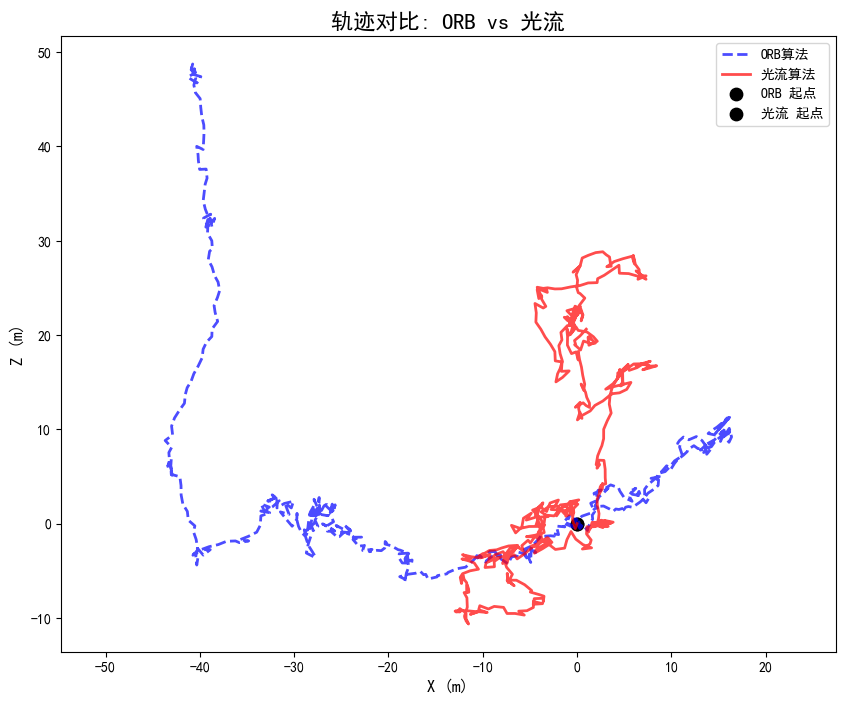

In [63]:
if len(traj_est_optflow) > 0:
    # traj_est 是实验一的结果变量
    plot_comparison(traj_est, traj_est_optflow)
else:
    print("光流法未生成有效轨迹。")

ORB和光流的起点一致，但轨迹完全不一样，体现了两种算法的差异性。ORB基于特征描述子匹配，而光流基于像素的运动估计。

我没有对光流算法下的单目VO（RGB图像）与GT进行时间戳对齐。因为可以预见的是，其尺度丢失也是必然的。

## RGB-D 光流 单目VO

基于官方文档的说明“The depth images are scaled by a factor of 5000...”，所以将depth_scale设置为5000.0。

In [81]:
# Cell 12: 数据关联与辅助函数

def associate_rgb_depth(rgb_list, rgb_times, depth_path):
    """
    将 RGB 图像列表与 Depth 图像文件进行时间戳对齐
    返回: [(rgb_file, depth_file, timestamp), ...]
    """
    # 1. 加载所有深度图文件和时间戳
    depth_files = []
    depth_times = []
    
    # 解析 depth.txt (类似 rgb.txt)
    depth_txt_path = os.path.join(depth_path, 'depth.txt')
    if not os.path.exists(depth_txt_path):
        # 如果没有 depth.txt，尝试直接遍历文件夹 (不推荐，但作为fallback)
        print("Warning: depth.txt not found.")
        return []
        
    with open(depth_txt_path, 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.strip().split()
            if len(parts) >= 2:
                depth_times.append(float(parts[0]))
                depth_files.append(os.path.join(depth_path, parts[1]))
                
    depth_times = np.array(depth_times)
    
    # 2. 对每一张 RGB 找最近的 Depth
    matches = []
    print(f"正在对齐 {len(rgb_list)} 帧 RGB 与深度图...")
    
    for i, rgb_t in enumerate(rgb_times):
        # 寻找最近的时间戳索引
        idx = np.abs(depth_times - rgb_t).argmin()
        diff = np.abs(depth_times[idx] - rgb_t)
        
        if diff < 0.04: # 允许最大误差 40ms
            matches.append((rgb_list[i], depth_files[idx], rgb_t))
            
    print(f"对齐完成，共 {len(matches)} 对 RGB-D 帧。")
    return matches

def get_true_pose_at_time(timestamp, gt_data, gt_times):
    """
    获取指定时间戳的 Ground Truth 位姿 (4x4 矩阵)
    """
    t_gt = find_nearest_timestamp(timestamp, gt_times)
    pos = gt_data[t_gt] # [x, y, z]
    # 这里为了简单，我们只拿位置初始化。
    # 如果要严谨，还需要四元数转旋转矩阵。
    # 鉴于TUM数据集通常包含四元数，我们去 load_groundtruth 稍微扩展一下会更好，
    # 但为了不破坏之前的代码结构，这里假设初始旋转是单位阵或近似。
    # **Trick**: 实际上，TUM GT 文件包含 qx,qy,qz,qw。
    # 为简化代码，我们仅对齐位置，旋转默认为单位阵（因为通常起点都在原点附近且放平）
    # 或者我们假设第一帧是世界坐标系原点。
    
    T = np.eye(4)
    T[:3, 3] = pos
    return T

In [82]:
# 复用之前加载的GT数据：
# gt_dict, gt_times_list = load_groundtruth(dataset_path)

# 复用之前的 load_images_from_tum 得到的列表：
# images, times = load_images_from_tum(dataset_path)

rgbd_pairs = associate_rgb_depth(images, times, dataset_path)

正在对齐 2965 帧 RGB 与深度图...
对齐完成，共 2965 对 RGB-D 帧。


In [83]:
# # Cell 13: 3D-2D 投影与 PnP 求解 (修复版)

# def pixel2cam(p, d, K):
#     """
#     像素坐标转相机坐标系 3D 点
#     """
#     fx, fy = K[0, 0], K[1, 1]
#     cx, cy = K[0, 2], K[1, 2]
    
#     x = (p[0] - cx) * d / fx
#     y = (p[1] - cy) * d / fy
#     z = d
#     return np.array([x, y, z])

# def get_3d_2d_correspondences(prev_pts, curr_pts, prev_depth_img, K):
#     """
#     构建 PnP 需要的 3D(上一帧) - 2D(当前帧) 对应关系
#     """
#     obj_pts = [] # 3D points in prev frame
#     img_pts = [] # 2D points in curr frame
    
#     depth_scale = 5000.0 # tum标准
    
#     # [修复] 统一输入形状为 (N, 2)
#     # 无论输入是 (N, 1, 2) 还是 (N, 2)，都reshape成 (N, 2)
#     prev_pts_flat = prev_pts.reshape(-1, 2)
#     curr_pts_flat = curr_pts.reshape(-1, 2)
    
#     for i in range(len(prev_pts_flat)):
#         # [修复] 现在使用 (i, 0) 和 (i, 1) 访问，或者直接解包
#         u, v = int(prev_pts_flat[i, 0]), int(prev_pts_flat[i, 1])
        
#         # 边界检查
#         if 0 <= v < prev_depth_img.shape[0] and 0 <= u < prev_depth_img.shape[1]:
#             d_raw = prev_depth_img[v, u]
            
#             if d_raw == 0: # 无效深度
#                 continue
                
#             d_meters = d_raw / depth_scale
#             if d_meters < 0.1 or d_meters > 10.0: # 过滤太近或太远的点
#                 continue
            
#             # 反投影到 3D
#             pt3d = pixel2cam([u, v], d_meters, K)
            
#             obj_pts.append(pt3d)
#             # 对应的当前帧 2D 点
#             img_pts.append(curr_pts_flat[i])
            
#     return np.array(obj_pts), np.array(img_pts)

In [84]:
# Cell 13: 3D-2D 投影与 PnP 求解 (修复畸变逻辑版)

def pixel2cam(p, d, K):
    """
    像素坐标转相机坐标系 3D 点 (输入的 p 必须是去畸变后的线性坐标)
    """
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    x = (p[0] - cx) * d / fx
    y = (p[1] - cy) * d / fy
    z = d
    return np.array([x, y, z])

def get_3d_2d_correspondences(prev_pts_distorted, curr_pts_distorted, prev_depth_img, K, dist_coef):
    """
    构建 PnP 需要的 3D(上一帧) - 2D(当前帧) 对应关系
    关键修复：先对特征点去畸变，再反投影为 3D 点
    """
    obj_pts = [] # 3D points in prev frame
    img_pts = [] # 2D points in curr frame
    
    depth_scale = 5000.0 # TUM 标准
    
    # 1. 整理形状 (N, 2)
    pts_dist = prev_pts_distorted.reshape(-1, 2)
    
    # 2. 核心步骤：对像素点进行去畸变
    # 使用 undistortPoints 将畸变像素点转换为去畸变后的像素点
    # P=K 让输出结果保持在像素坐标系下 (u, v)，而不是归一化平面
    pts_undist = cv2.undistortPoints(pts_dist, K, dist_coef, P=K).reshape(-1, 2)
    
    # 3. 遍历点对
    for i in range(len(pts_dist)):
        # A. 查深度：必须用原始畸变坐标 (u_dist, v_dist)，因为深度图和RGB图是一一对应的
        u_dist, v_dist = int(pts_dist[i, 0]), int(pts_dist[i, 1])
        
        # 边界检查
        if 0 <= v_dist < prev_depth_img.shape[0] and 0 <= u_dist < prev_depth_img.shape[1]:
            d_raw = prev_depth_img[v_dist, u_dist]
            
            if d_raw == 0: continue
            
            d_meters = d_raw / depth_scale
            if d_meters < 0.1 or d_meters > 10.0: continue
            
            # B. 算3D：必须用去畸变坐标 (u_undist, v_undist)，符合针孔模型
            # 这里的 pts_undist[i] 已经是线性的理想像素坐标
            pt3d = pixel2cam(pts_undist[i], d_meters, K)
            
            obj_pts.append(pt3d)
            
            # C. PnP的目标2D点：保持畸变坐标
            # solvePnP 会接受 dist_coef 参数，内部处理 img_pts 的畸变
            img_pts.append(curr_pts_distorted.reshape(-1, 2)[i])
            
    return np.array(obj_pts), np.array(img_pts)

In [85]:
# # Cell 14: RGB-D 光流 VO 主循环 (修复版)

# def run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times):
#     trajectory = []
    
#     # === 1. 初始化 (Trick: 使用 GT 对齐第一帧) ===
#     first_rgb_path, first_depth_path, first_time = rgbd_pairs[0]
    
#     # 获取初始 GT 位姿
#     T_w_c = get_true_pose_at_time(first_time, gt_dict, gt_times)
    
#     trajectory.append(T_w_c[:3, 3]) # 记录初始位置
    
#     # 读取第一帧
#     prev_img = cv2.imread(first_rgb_path)
#     prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
#     prev_depth = cv2.imread(first_depth_path, cv2.IMREAD_UNCHANGED)
    
#     # 提取初始特征点
#     prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
#     print(f"RGB-D VO 开始运行，初始对齐位置: {T_w_c[:3, 3]}")
    
#     # === 2. 循环处理 ===
#     # 跑前 800 帧进行演示
#     for i in range(1, min(len(rgbd_pairs), 800)):
#         curr_rgb_path, curr_depth_path, curr_time = rgbd_pairs[i]
        
#         curr_img = cv2.imread(curr_rgb_path)
#         curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
#         curr_depth = cv2.imread(curr_depth_path, cv2.IMREAD_UNCHANGED)
        
#         # --- A. 光流追踪 ---
#         if prev_pts is None or len(prev_pts) < 10:
#             prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
#             prev_gray = curr_gray
#             prev_depth = curr_depth
#             continue

#         curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
#         # 筛选有效点
#         # status 是一维数组或 (N,1) 数组，会导致 good_new 变成 (M, 2)
#         good_new = curr_pts[status.flatten() == 1]
#         good_old = prev_pts[status.flatten() == 1]
        
#         # --- B. PnP 位姿估计 ---
#         if len(good_new) > 10:
#             # 获取 3D-2D 对应关系
#             # 这里的 good_old/good_new 已经是 (M, 2) 形状，传入修复后的函数没问题
#             obj_pts, img_pts = get_3d_2d_correspondences(good_old, good_new, prev_depth, K)
            
#             if len(obj_pts) > 8:
#                 # Solve PnP
#                 success, rvec, tvec, inliers = cv2.solvePnPRansac(
#                     obj_pts, img_pts, K, dist_coef, 
#                     iterationsCount=100, reprojectionError=2.0
#                 )
                
#                 if success:
#                     R_rel, _ = cv2.Rodrigues(rvec)
#                     t_rel = tvec
                    
#                     # 构建 T_prev_curr
#                     T_prev_curr = np.eye(4)
#                     T_prev_curr[:3, :3] = R_rel
#                     T_prev_curr[:3, 3] = t_rel.flatten()
                    
#                     # 更新全局位姿: T_w_curr = T_w_prev * (T_prev_curr)^-1
#                     try:
#                         T_curr_prev = np.linalg.inv(T_prev_curr)
#                         T_w_c = T_w_c @ T_curr_prev
#                     except np.linalg.LinAlgError:
#                         pass # 忽略奇异矩阵
                    
#         # 记录轨迹
#         trajectory.append(T_w_c[:3, 3])
        
#         # --- C. 特征点补充 ---
#         if len(good_new) < 1500:
#             new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
#             prev_pts = new_pts
#         else:
#             # 保持为 (N, 1, 2) 以便下一轮光流输入，这是 calcOpticalFlowPyrLK 偏好的格式
#             prev_pts = good_new.reshape(-1, 1, 2)
            
#         prev_gray = curr_gray
#         prev_depth = curr_depth
        
#         if i % 100 == 0:
#             print(f"Frame {i}: Pose {T_w_c[:3, 3]}")

#     return np.array(trajectory)

In [91]:
# Cell 14: RGB-D 光流 VO 主循环 (最终修复版)

def run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times):
    trajectory = []
    
    # === 1. 初始化 ===
    first_rgb_path, first_depth_path, first_time = rgbd_pairs[0]
    
    # Trick: 使用 GT 对齐第一帧
    T_w_c = get_true_pose_at_time(first_time, gt_dict, gt_times)
    trajectory.append(T_w_c[:3, 3]) 
    
    prev_img = cv2.imread(first_rgb_path)
    prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    prev_depth = cv2.imread(first_depth_path, cv2.IMREAD_UNCHANGED)
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    
    print(f"RGB-D VO (Fixed) 开始运行...")
    
    # === 2. 循环处理 ===
    # 建议跑前 800-1000 帧看效果
    for i in range(1, min(len(rgbd_pairs), 600)):
        curr_rgb_path, curr_depth_path, curr_time = rgbd_pairs[i]
        
        curr_img = cv2.imread(curr_rgb_path)
        curr_gray = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
        curr_depth = cv2.imread(curr_depth_path, cv2.IMREAD_UNCHANGED)
        
        # 特征点丢失重置
        if prev_pts is None or len(prev_pts) < 10:
            prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
            prev_gray = curr_gray
            prev_depth = curr_depth
            continue

        # 光流追踪
        curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None, **lk_params)
        
        # 筛选有效点
        good_new = curr_pts[status.flatten() == 1]
        good_old = prev_pts[status.flatten() == 1]
        
        if len(good_new) > 10:
            # [关键修改] 传入 dist_coef，让函数内部进行 undistortPoints
            obj_pts, img_pts = get_3d_2d_correspondences(good_old, good_new, prev_depth, K, dist_coef)
            
            if len(obj_pts) > 8:
                # Solve PnP
                # 此时 obj_pts 是几何正确的 3D 点，img_pts 是原始畸变 2D 点
                # solvePnPRansac 会利用 K 和 dist_coef 正确处理 img_pts
                success, rvec, tvec, inliers = cv2.solvePnPRansac(
                    obj_pts, img_pts, K, dist_coef, 
                    iterationsCount=100, reprojectionError=3.0
                )
                
                if success:
                    R_rel, _ = cv2.Rodrigues(rvec)
                    # 更新全局位姿
                    T_prev_curr = np.eye(4)
                    T_prev_curr[:3, :3] = R_rel
                    T_prev_curr[:3, 3] = tvec.flatten()
                    
                    try:
                        T_curr_prev = np.linalg.inv(T_prev_curr)
                        T_w_c = T_w_c @ T_curr_prev
                    except: pass
                    
        trajectory.append(T_w_c[:3, 3])
        
        # 补充特征点
        if len(good_new) < 1500:
            new_pts = cv2.goodFeaturesToTrack(curr_gray, mask=None, **feature_params)
            prev_pts = new_pts
        else:
            prev_pts = good_new.reshape(-1, 1, 2)
            
        prev_gray = curr_gray
        prev_depth = curr_depth
        
        if i % 100 == 0:
            print(f"Frame {i}: Pos {T_w_c[:3, 3]}")

    return np.array(trajectory)

In [92]:
traj_rgbd = run_rgbd_vo(rgbd_pairs, K, dist_coef, gt_dict, gt_times_list)
print("RGB-D 光流 VO 完成。")

RGB-D VO (Fixed) 开始运行...
Frame 100: Pos [ 0.43275994 -1.32740807  1.20322385]
Frame 200: Pos [ 0.7842406  -1.59800876  1.45009446]
Frame 300: Pos [ 1.24154024 -1.71293424  1.92411544]
Frame 400: Pos [ 1.24315422 -2.08515788  2.53427451]
Frame 500: Pos [ 1.88003776 -2.19837366  2.81013637]
RGB-D 光流 VO 完成。


In [93]:
# Cell 15: RGB-D 轨迹 vs Ground Truth 可视化

def plot_rgbd_vs_gt(traj_est, gt_dict, rgb_times):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # 提取对应时间段的 GT 用于画图
    # 简单的取所有GT画出来背景，或者取对应时间段的
    gt_all = np.array(list(gt_dict.values()))
    
    # 绘制
    ax.plot(gt_all[:, 0], gt_all[:, 2], label='Ground Truth', color='black', alpha=0.3)
    ax.plot(traj_est[:, 0], traj_est[:, 2], label='RGB-D VO (Estimated)', color='blue', linewidth=2)
    
    # 标记起点
    ax.scatter(traj_est[0, 0], traj_est[0, 2], c='red', s=100, label='Start Point (Aligned)')
    
    ax.set_title('Experiment 4: RGB-D VO vs Ground Truth', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=12)
    ax.set_ylabel('Z (m)', fontsize=12)
    ax.legend()
    ax.axis('equal')
    plt.show()

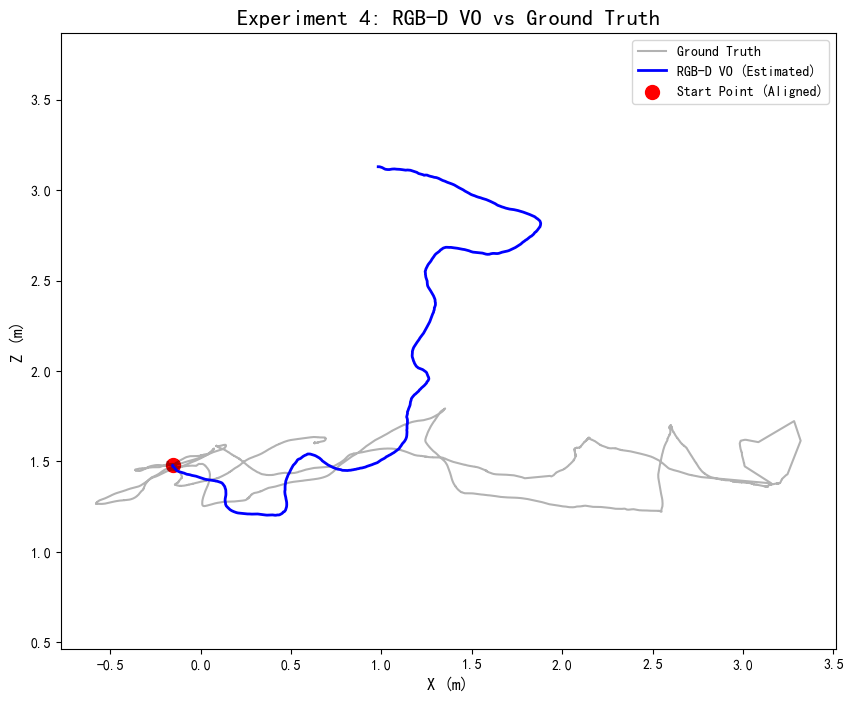

In [94]:
# 提取用于画图的时间戳范围
# (实际上我们只画出了估算的轨迹点，背景用完整的GT轨迹即可)
plot_rgbd_vs_gt(traj_rgbd, gt_dict, times)